# Estimation on simulated data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD
import time

# Global modules
import numpy as np

# Singles

In [ ]:
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

Single = RetirementClass(simN=1e5,simT=12)
Single.solve()
Single.simulate()
mom_data = SMD.MomFunSingle(Single.sim,Single.par)
mom_se = SMD.MomFunSingle(Single.sim,Single.par,std=True)
weight = weight_matrix(mom_se)

Set up model for estimation

In [ ]:
Single.sim_seed = Single.sim_seed + 1000 # set new seed for estimation
Single.recompute()

In [ ]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunSingle(sim,Single.par)

Set up estimation

In [8]:
# Parameters to be estimated (and guess)
true = [Single.par.alpha_0_male, Single.par.alpha_0_female, Single.par.alpha_1, Single.par.sigma_eta]
theta0 = true
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta"]

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun,print_iter=[True,100],options={'disp':True})
smd.est_par = est_par

Run estimation

In [9]:
tic = time.time()
smd_base.estimate(theta0,weight)
theta = smd.est
toc = time.time()

Iteration: 50 (0.73 minutes)
 alpha_0_male=0.1629 alpha_0_female=0.2254 alpha_1=0.0701 sigma_eta=0.5243 -> 49.6945
Iteration: 100 (0.72 minutes)
 alpha_0_male=0.1463 alpha_0_female=0.1490 alpha_1=0.0700 sigma_eta=0.4121 -> 3.0982
Iteration: 150 (0.74 minutes)
 alpha_0_male=0.1481 alpha_0_female=0.1496 alpha_1=0.0698 sigma_eta=0.4166 -> 3.0131
Iteration: 200 (0.73 minutes)
 alpha_0_male=0.1480 alpha_0_female=0.1496 alpha_1=0.0698 sigma_eta=0.4168 -> 3.0012
Iteration: 250 (0.75 minutes)
 alpha_0_male=0.1480 alpha_0_female=0.1495 alpha_1=0.0698 sigma_eta=0.4167 -> 2.9942
Optimization terminated successfully.
         Current function value: 2.992020
         Iterations: 149
         Function evaluations: 268


Result

In [10]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 4))
print('Estimated:       ', np.round(theta, 4))
print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/60,1), 'minutes')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta']
True:             [0.16  0.16  0.053 0.435]
Estimated:        [0.148 0.15  0.07  0.417]
bias:             [-0.012 -0.01   0.017 -0.018]
Estimation time:  3.93 minutes


clean up

In [ ]:
%reset -f

# Couples

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import setup
import SimulatedMinimumDistance as SMD
import time

# Global modules
import numpy as np

Set up model

In [2]:
CoupleEst,SingleEst = SMD.load_est(name='Couple',couple=True)
CoupleEst['simT'] = 68-53+1
CoupleEst['simN'] = int(1e6)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
Couple.solve()
Couple.simulate()

In [29]:
Couple.par.Nxi = 1
Couple.par.Nxi_men = 1
Couple.par.Nxi_women = 1
Couple.Single.par.Nxi = 1
Couple.par.var[:] = 0
Couple.par.cov = 0
Couple.Single.par.var[:] = 0
Couple.solve(recompute=True)
Couple.simulate()

Set up moments and weight matrix

In [32]:
# create weight matrix
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0.1)[0]
    std_inv[idx] = 1/std[idx]#std[idx]#1/std[idx]
    return np.eye(std.size)*std_inv

# function to generate moments
def mom_fun(sim):
    return SMD.MomFunCouple(sim,Couple.par)

mom_data = SMD.MomFunCouple(Couple.sim,Couple.par)
mom_se = SMD.MomFunCouple(Couple.sim,Couple.par,calc='std')
weight = weight_matrix(mom_se)

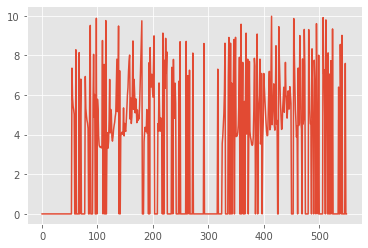

In [35]:
plt.plot(np.diag(weight))

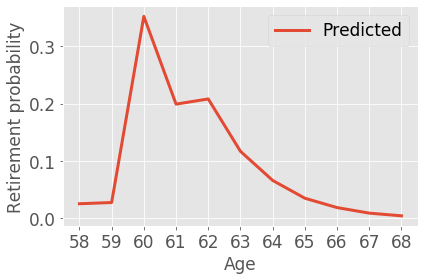

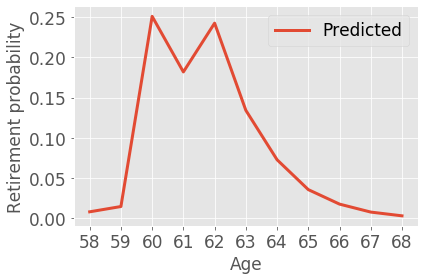

In [39]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0),linewidth=3,save=False)
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1),linewidth=3,save=False)

Set new seed

In [40]:
Couple.par.sim_seed = Couple.par.sim_seed + 1
Couple.solve(recompute=True)

Set up estimation

In [41]:
par = Couple.par
true = [par.alpha_0_male, par.alpha_0_female, par.alpha_1, par.sigma_eta, par.phi_0_male, par.phi_0_female, par.phi_1]

In [60]:
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_0_female", "phi_1"]
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0^m$', r'$\phi_0^f$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.print_iter = [True,50]
smd.options['adaptive'] = True
smd.est_par = est_par

In [61]:
theta0 = [(0.1, 0.1, 0.1, 0.5, 1.0, 1.0, 0.5),
          (0.5, 0.5, 0.2, 0.5, 1.5, 1.5, -0.5),
          (1.0, 1.0, 0.3, 0.5, 0.5, 0.5, 0.5),
          (0.1, 0.1, -0.1, 0.5, 1.0, 1.0, -0.5),
          (0.5, 0.5, -0.2, 0.5, 1.5, 1.5, 0.5),
          (1.0, 1.0, -0.3, 0.5, 0.5, 0.5, -0.5)]

In [62]:
smd.obj_fun(true,weight)

0.36024970529735484

Run estimation

In [74]:
smd.MultiStart(theta0,weight)
theta = smd.est

KeyboardInterrupt: 

# OLD

In [13]:
tic = time.time()
smd.MultiStart(theta0[0:3],weight)
theta = smd.est
toc = time.time()

Iteration: 10 (9.02 minutes)
 alpha_0_male=0.1014 alpha_0_female=0.1014 alpha_1=0.1014 sigma_eta=0.5071 phi_0_male=1.0143 phi_0_female=1.0143 phi_1=0.5071 -> 51.4019
Iteration: 20 (6.24 minutes)
 alpha_0_male=0.1024 alpha_0_female=0.1041 alpha_1=0.1038 sigma_eta=0.5507 phi_0_male=0.9526 phi_0_female=0.9612 phi_1=0.4799 -> 50.0704
Iteration: 30 (5.6 minutes)
 alpha_0_male=0.1083 alpha_0_female=0.1132 alpha_1=0.0998 sigma_eta=0.6303 phi_0_male=0.8011 phi_0_female=0.9315 phi_1=0.5196 -> 47.5311
Iteration: 40 (5.41 minutes)
 alpha_0_male=0.1191 alpha_0_female=0.1432 alpha_1=0.1020 sigma_eta=0.9164 phi_0_male=0.1777 phi_0_female=0.7039 phi_1=0.5256 -> 42.0516
Iteration: 50 (5.39 minutes)
 alpha_0_male=0.1478 alpha_0_female=0.2157 alpha_1=0.1097 sigma_eta=1.5383 phi_0_male=-1.2449 phi_0_female=0.2669 phi_1=0.5960 -> 38.2769
Iteration: 60 (5.56 minutes)
 alpha_0_male=0.1507 alpha_0_female=0.2115 alpha_1=0.0932 sigma_eta=1.4227 phi_0_male=-0.8368 phi_0_female=0.3065 phi_1=0.5556 -> 38.2501
Ite

Results

In [14]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 4))
print('Estimated:       ', np.round(theta, 4))
print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/60,1), 'minutes')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta', 'phi_0_male', 'phi_0_female', 'phi_1']
True:             [ 0.4    0.4    0.053  0.435  1.187  1.671 -0.621]
Estimated:        [ 0.3922  0.4039  0.0893  0.4353  1.0701  1.8375 -0.7984]
bias:             [-0.0078  0.0039  0.0363  0.0003 -0.1169  0.1665 -0.1774]
Estimation time:  757.5 minutes


In [15]:
757.5/60

12.625

In [16]:
smd.obj_fun(true,weight)

0.06778829145018261

In [17]:
Nobs = 5000
smd.std_error(true,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', true)
print('Std error :', std_error)

Iteration: 1430 (354.52 minutes)
 alpha_0_male=0.3999 alpha_0_female=0.4000 alpha_1=0.0530 sigma_eta=0.4350 phi_0_male=1.1870 phi_0_female=1.6710 phi_1=-0.6210 -> 0.0680
Iteration: 1440 (5.99 minutes)
 alpha_0_male=0.4000 alpha_0_female=0.4000 alpha_1=0.0530 sigma_eta=0.4350 phi_0_male=1.1870 phi_0_female=1.6708 phi_1=-0.6210 -> 0.0678
Parameters: [ 0.3921751   0.40389683  0.08932575  0.4353478   1.07013947  1.83749986
 -0.79836521]
Std error : [1.03240008e-05 2.57347904e-05 1.30382949e-05 1.40848910e-05
 4.65796160e-05 4.42279122e-05 5.40800506e-05]


In [23]:
lam = smd.sens1

In [33]:
lam0 = lam[0].reshape(2,11,9+16)

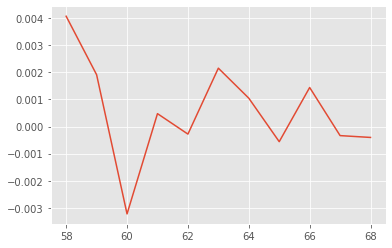

In [48]:
plt.plot(np.arange(58,69),np.mean(lam0,axis=(0,2)))

In [57]:
ww = np.diag(weight).reshape(2,11,9+16)

In [158]:
# create weight matrix
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0.0000000000000001)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

weight = weight_matrix(mom_se)

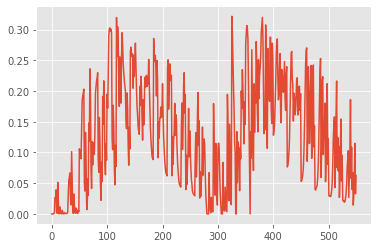

In [159]:
plt.plot(mom_se)

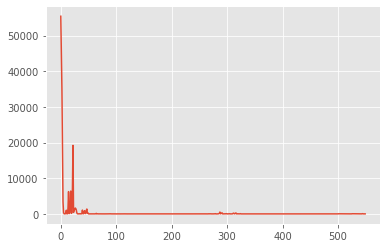

In [160]:
plt.plot(np.diag(weight))

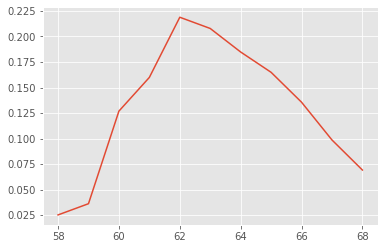

In [161]:
plt.plot(np.arange(58,69), np.mean(mom_se.reshape(2,11,25),axis=(0,2)))

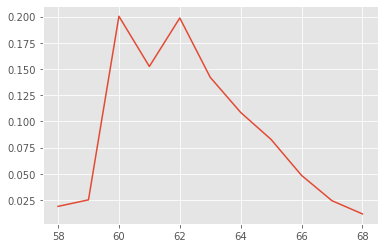

In [140]:
plt.plot(np.arange(58,69), np.mean(mom_data.reshape(2,11,25),axis=(0,2)))

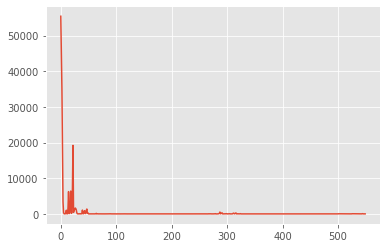

In [141]:
plt.plot(np.diag(weight))

In [133]:
ww = np.diag(weight).reshape(2,11,25)

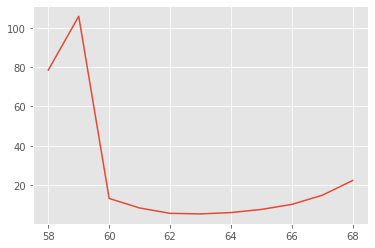

In [134]:
plt.plot(np.arange(58,69),np.mean(ww,axis=(0,2)))

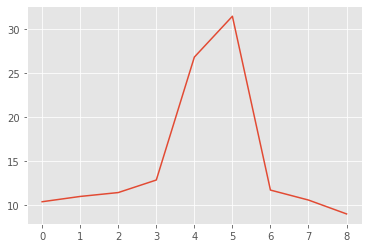

In [135]:
plt.plot(np.mean(ww,axis=(0,1))[0:9])

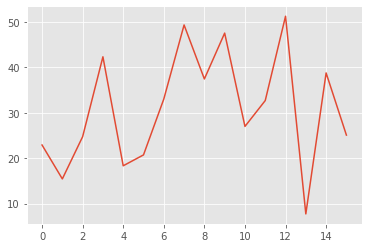

In [136]:
plt.plot(np.mean(ww,axis=(0,1))[9:])

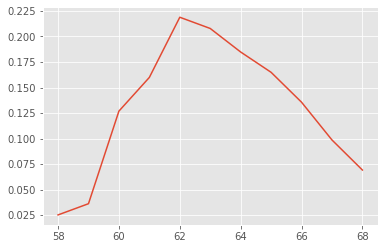

In [98]:
plt.plot(np.arange(58,69),np.mean(mom_se.reshape(2,11,25),axis=(0,2)))

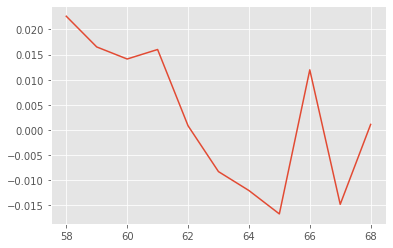

In [44]:
plt.plot(np.arange(58,69),lam0[0,:,-1])

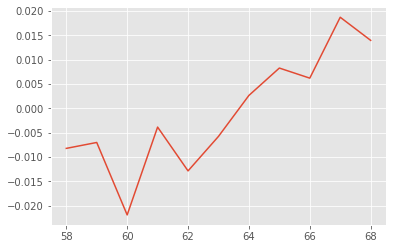

In [45]:
plt.plot(np.arange(58,69),lam0[1,:,-1])

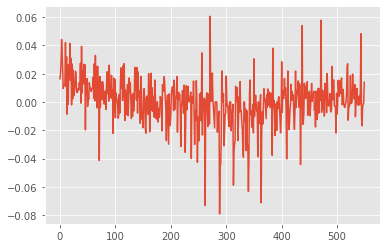

In [29]:
plt.plot(lam[0])

In [28]:
import matplotlib.pyplot as plt

In [20]:
mom_data.shape

(550,)

In [21]:
len(theta)

7

In [22]:
theta

array([ 0.3921751 ,  0.40389683,  0.08932575,  0.4353478 ,  1.07013947,
        1.83749986, -0.79836521])

In [ ]:
Nobs = 5000
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', theta)
print('Std error :', std_error)

In [4]:
Couple.solve()    
Couple.simulate()

In [5]:
mom_data = SMD.MomFunCouple(Couple.sim,Couple.par)
mom_se = SMD.MomFunCouple(Couple.sim,Couple.par,calc='std')
weight = weight_matrix(mom_se)

C:\Users\Frederik\Desktop\Speciale_retirement\Main\SimulatedMinimumDistance.py:307: RuntimeWarning: Mean of empty slice
  mom[1,:,i] = np.nanmean(probs_w[idx],axis=0)
C:\Users\Frederik\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [21]:
est_par = []
true = []
seed = 2019 # from Couple.par
for key,val in CoupleEst.items():
    if not key == 'simT':
        est_par.append(key)
        true.append(val)

In [14]:
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

In [16]:
smd.obj_fun(true,weight)

C:\Users\Frederik\Desktop\Speciale_retirement\Main\SimulatedMinimumDistance.py:307: RuntimeWarning: Mean of empty slice
  mom[1,:,i] = np.nanmean(probs_w[idx],axis=0)


0.0

Simulate data and compute moments

In [281]:
Couple.par.sim_seed = 2019
Couple.solve(recompute=True)
Couple.simulate()

In [282]:
mom_data = SMD.MomFunCouple(Couple.sim,Couple.par)
mom_se = SMD.MomFunCouple(Couple.sim,Couple.par,calc='std')
weight = weight_matrix(mom_se)

Set new seed and evaluate obj as function of N

In [283]:
def obj(model,theta,mom_data,W,mom_fun,est_par,recompute=False,*args):
    # 1. update parameters 
    for i in range(len(est_par)):
        setattr(model.par,est_par[i],theta[i]) # like par.key = val
        if model.couple and hasattr(model.Single.par,est_par[i]):
            setattr(model.Single.par,est_par[i],theta[i]) # update also in nested single model                
    # 2. solve model with current parameters
    model.solve(recompute=recompute)
    # 3. simulate data from the model and calculate moments [have this as a complete function, used for standard errors]
    model.simulate()
    mom_sim = mom_fun(model.sim,*args)
    # 4. calculate objective function and return it
    diff = mom_data - mom_sim
    obj  = ((np.transpose(diff) @ W) @ diff)
    return obj

In [284]:
Couple.par.sim_seed = 2020

In [286]:
x = np.linspace(int(1e5), int(1e6), 6)
y = []
for N in x:
    Couple.par.simN = int(N)
    yx = obj(Couple,true,mom_data,weight,mom_fun,est_par,recompute=True)
    y.append(yx)
    print(yx)

0.4359242723252663
0.21299156930372695
0.08895388642537078
0.07505371638407046
0.04508305023798599
0.06628740635434019


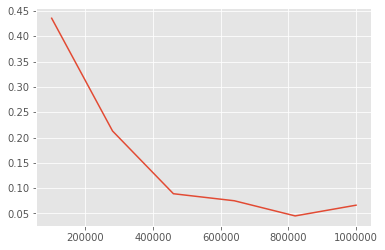

In [288]:
plt.plot(x,y)

In [ ]:
#Couple.par.sim_seed = 2019
#Couple.par.simN = int(1e6)
#Couple.solve(recompute=True)
#Couple.simulate()

In [279]:
mom_data = SMD.MomFunCouple(Couple.sim,Couple.par)
mom_se = SMD.MomFunCouple(Couple.sim,Couple.par,calc='std')
weight = weight_matrix(mom_se)

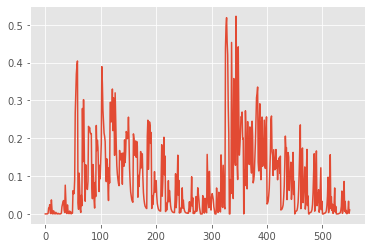

In [258]:
plt.plot(mom_data)

In [259]:
mom_re = mom_data.reshape((2,11,25))

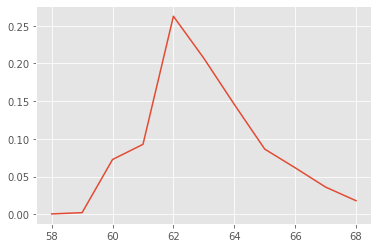

In [277]:
plt.plot(np.arange(58,69),mom_re[0,:,-1])

In [261]:
sim = Couple.sim

In [262]:
ad = 0
idx = np.nonzero(sim.states[:,0]==ad)[0]

In [265]:
y = sim.probs[idx,:,0]
y = np.nanmean(y,axis=0)
y

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


array([           nan,            nan,            nan,            nan,
                  nan, 9.19754340e-03, 1.87637695e-02, 4.19221419e-01,
       2.55540076e-01, 1.87984114e-01, 6.86835541e-02, 2.38636635e-02,
       9.70734156e-03, 3.96484625e-03, 1.75636269e-03, 7.05276324e-04,
       3.13914364e-04, 1.21646423e-04, 5.84818585e-05, 2.06929985e-05,
                  nan,            nan,            nan,            nan])

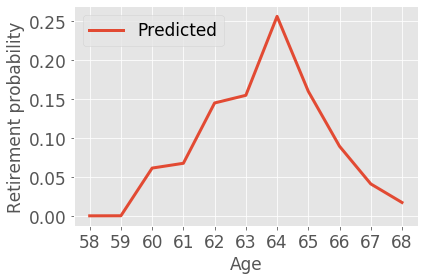

In [274]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1,AD=[-4]),linewidth=3,save=False)

Check objective as a function of N

In [109]:
def obj(model,theta,mom_data,W,mom_fun,est_par,recompute=False,*args):
       
    # 1. update parameters 
    for i in range(len(est_par)):
        setattr(model.par,est_par[i],theta[i]) # like par.key = val
        if model.couple and hasattr(model.Single.par,est_par[i]):
            setattr(model.Single.par,est_par[i],theta[i]) # update also in nested single model                

    # 2. solve model with current parameters
    model.solve(recompute=recompute)

    # 3. simulate data from the model and calculate moments [have this as a complete function, used for standard errors]
    model.simulate()
    mom_sim = mom_fun(model.sim,*args)

    # 4. calculate objective function and return it
    diff = mom_data - mom_sim
    obj  = ((np.transpose(diff) @ W) @ diff)

    return obj

In [110]:
obj(Couple,true,mom_data,weight,mom_fun,est_par)

0.0

In [112]:
Couple.par.simN = int(1e5)
Couple.recompute()
obj(Couple,true,mom_data,weight,mom_fun,est_par)

301.46610357761216

In [118]:
mom_data.shape

(3366,)

In [119]:
mom_sim = mom_fun(Couple.sim)

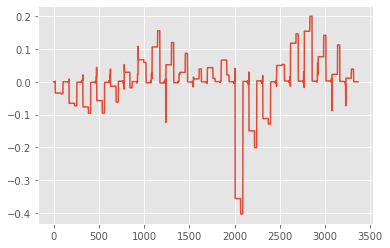

In [124]:
plt.plot(mom_data - mom_sim)

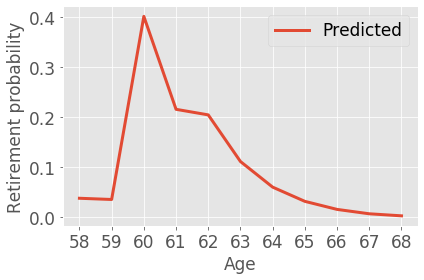

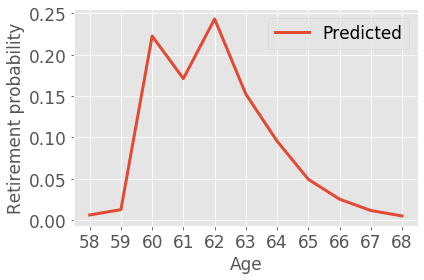

In [130]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0),linewidth=3,save=False)
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1),linewidth=3,save=False)

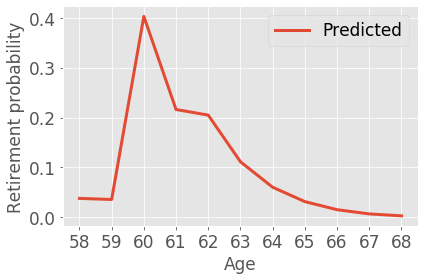

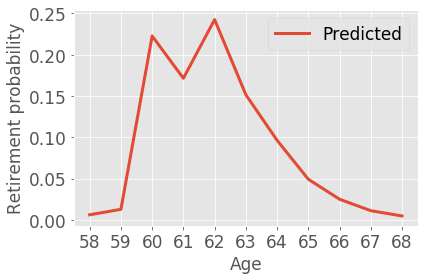

In [116]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0),linewidth=3,save=False)
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1),linewidth=3,save=False)

In [90]:
y = []
x = []
Couple.par.sim_seed = 2020
for N in np.linspace(1e5, 1e6, 6):
    Couple.par.simN = int(N)
    Couple.recompute()
    Couple.Single.recompute()
    obj = smd.obj_fun(true,weight)
    print(obj)
    y.append(obj)
    x.append(int(N))

1.5455724214563316
50.39072141126063


KeyboardInterrupt: 

In [53]:
[100, 100*10, 100*10*10]

[100, 1000, 10000]

In [54]:
np.linspace(1e2, 1e6, 6)

array([1.0000e+02, 2.0008e+05, 4.0006e+05, 6.0004e+05, 8.0002e+05,
       1.0000e+06])

In [56]:
store = []
for N in np.linspace(1e2, 1e6, 6):
    Couple.par.simN = int(N)
    setup.init_sim(Couple.par,Couple.sim)
    store.append(smd.obj_fun(true,weight))

100
200080
400060
600040
800020
1000000


In [ ]:
for N in [100, 100]

In [41]:
Couple.par.simN

100000

In [42]:
Couple.par.simT

12

In [28]:
smd.obj_fun(true,weight)

1.8584614558297465

In [26]:
smd.obj_fun(true,weight)

1.8530679762513578

In [2]:
# create weight matrix
def weight_matrix(std):
    std_inv = np.zeros(std.shape)
    idx = np.nonzero(std>0)[0]
    std_inv[idx] = 1/std[idx]
    return np.eye(std.size)*std_inv

Couple = RetirementClass(couple=True, simN=int(1e5), simT=12)
#single_kw = {'Nxi': 1}
#couple_kw = {'simN': int(1e5), 'simT': 12, 'var': np.zeros(2), 'cov': 0, 'Nxi': 1, 'Nxi_men': 1, 'Nxi_women': 1}
#Couple = RetirementClass(couple=True, single_kwargs=single_kw, **couple_kw)
Couple.solve()    
Couple.simulate()
mom_data = SMD.MomFunCouple(Couple.sim,Couple.par)
mom_se = SMD.MomFunCouple(Couple.sim,Couple.par,calc='std')
weight = weight_matrix(mom_se)

C:\Users\Frederik\Desktop\Speciale_retirement\Main\SimulatedMinimumDistance.py:302: RuntimeWarning: Mean of empty slice
  for i in range(len(ADx)):
C:\Users\Frederik\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [3]:
Couple.par.sim_seed = Couple.par.sim_seed + 1000 # set new seed for estimation
Couple.recompute()

In [4]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunCouple(sim,Couple.par)

In [16]:
par = Couple.par
#true = [par.alpha_0_male, par.alpha_0_female, par.alpha_1, par.sigma_eta, par.phi_0_male, par.phi_0_female, par.phi_1]
true = [0.4,0.4,0.053,0.435,1.187,1.671,-0.621]

In [17]:
theta0 = [(0.1, 0.1, 0.1, 0.5, 1.0, 0.5, 0.5),
          (0.5, 0.5, 0.2, 0.5, 1.5, -0.5, -0.5),
          (1.0, 1.0, 0.3, 0.5, 0.5, 1.0, 0.5),
          (0.1, 0.1, -0.1, 0.5, 1.5, -1.0, 0.5),
          (0.5, 0.5, -0.2, 0.5, 0.2, 0.2, -0.5),
          (1.0, 1.0, -0.3, 0.5, 1.0, -0.2, 0.5)]

In [18]:
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_0_female", "phi_1"]
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0^m$', r'$\phi_0^f$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,print_iter=[True,10],options={'disp':True})
smd.est_par = est_par

In [15]:
smd.obj_fun([0.4,0.4,0.053,0.435,1.187,1.671,-0.621],weight)

1.866687260931295

In [19]:
smd.MultiStart(theta0,weight)
theta = smd.est

Iteration: 10 (3.86 minutes)
 alpha_0_male=0.0986 alpha_0_female=0.1018 alpha_1=0.1018 sigma_eta=0.5092 phi_0_male=0.9541 phi_0_female=0.5092 phi_1=0.5092 -> 423.9720
Iteration: 20 (4.05 minutes)
 alpha_0_male=0.0964 alpha_0_female=0.1049 alpha_1=0.1032 sigma_eta=0.5545 phi_0_male=0.9588 phi_0_female=0.5048 phi_1=0.4801 -> 415.2231
Iteration: 30 (3.87 minutes)
 alpha_0_male=0.0890 alpha_0_female=0.1147 alpha_1=0.1099 sigma_eta=0.6530 phi_0_male=0.8718 phi_0_female=0.4978 phi_1=0.4028 -> 397.5247
Iteration: 40 (4.23 minutes)
 alpha_0_male=0.0887 alpha_0_female=0.1397 alpha_1=0.1211 sigma_eta=0.8521 phi_0_male=0.5419 phi_0_female=0.4290 phi_1=0.3592 -> 368.6364
Iteration: 50 (4.52 minutes)
 alpha_0_male=0.0395 alpha_0_female=0.2304 alpha_1=0.1600 sigma_eta=1.4789 phi_0_male=-0.1065 phi_0_female=0.4068 phi_1=-0.0360 -> 342.6859
Iteration: 60 (4.13 minutes)
 alpha_0_male=0.0459 alpha_0_female=0.2377 alpha_1=0.1607 sigma_eta=1.4852 phi_0_male=-0.1896 phi_0_female=0.3840 phi_1=-0.0432 -> 342

KeyboardInterrupt: 

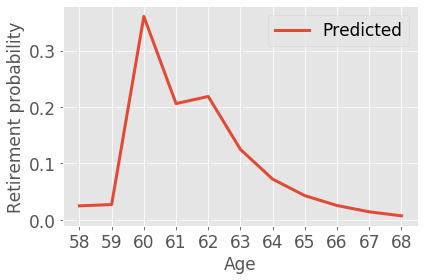

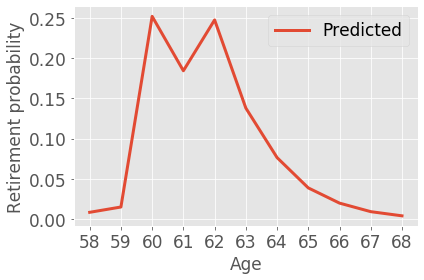

In [3]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0),linewidth=3,save=False)
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1),linewidth=3,save=False)

In [4]:
import time
tic1 = time.time()
Couple.solve()
tic2 = time.time()
Couple.simulate()
tic3 = time.time()
print(tic2-tic1)
print(tic3-tic2)

3.4362056255340576
2.841313600540161


Set up model for estimation 

In [5]:
Couple.par.sim_seed = Couple.par.sim_seed + 1000 # set new seed for estimation
Couple.recompute()

In [6]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunCouple(sim,Couple.par)

Set up estimation

In [23]:
# Parameters to be estimated (and guess)
true = [0.4, 0.4, 0.053, 1.187, 1.671, -0.621, 0.435]
#theta0 = [[i+0.05 for i in true], 
#          [i+0.05*2 for i in true],
#          [i+0.05*3 for i in true],
#          [i+0.05*4 for i in true],
#          [i-0.05 for i in true], 
#          [i-0.05*2 for i in true],
#          [i-0.05*3 for i in true],
#          [i-0.05*4 for i in true]]

#theta0 = [(0.1, 0.1, 0.1, 1.0, 1.0, 0.5, 0.5),
#          (0.5, 0.5, 0.2, 1.5, 1.5, -0.5, 0.5),
#          (1.0, 1.0, 0.3, 0.5, 0.5, 1.0, 0.5),
#          (0.1, 0.1, -0.1, 1.5, 1.5, -1.0, 0.5),
#          (0.5, 0.5, -0.2, 0.2, 0.2, 0.2, 0.5),
#          (1.0, 1.0, -0.3, 1.0, 1.0, -0.2, 0.5)]
theta0 = [true]

add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_0_female", "phi_1"]
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0^m$', r'$\phi_0^f$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,print_iter=[True,1],options={'disp':True})
smd.est_par = est_par

In [24]:
smd.MultiStart(theta0,weight)
theta = smd.est

Iteration: 1 (0.01 minutes)
 alpha_0_male=0.4000 alpha_0_female=0.4000 alpha_1=0.0530 sigma_eta=1.1870 phi_0_male=1.6710 phi_0_female=-0.6210 phi_1=0.4350 -> 234.7564
Iteration: 2 (0.13 minutes)
 alpha_0_male=0.4200 alpha_0_female=0.4000 alpha_1=0.0530 sigma_eta=1.1870 phi_0_male=1.6710 phi_0_female=-0.6210 phi_1=0.4350 -> 229.2167
Iteration: 3 (0.13 minutes)
 alpha_0_male=0.4000 alpha_0_female=0.4200 alpha_1=0.0530 sigma_eta=1.1870 phi_0_male=1.6710 phi_0_female=-0.6210 phi_1=0.4350

KeyboardInterrupt: 

In [10]:
smd.MultiStart(theta0,weight)
theta = smd.est

C:\Users\Frederik\Desktop\Speciale_retirement\Main\SimulatedMinimumDistance.py:302: RuntimeWarning: Mean of empty slice
  mom[1,:,i] = np.nanmean(probs_w[idx],axis=0)


1 estimation:
success: True | feval: 325 | time: 36.0 min | obj: 4.018687952609
start par: [0.45, 0.45, 0.10300000000000001, 1.237, 1.721, -0.571, 0.485]
par:       [ 0.57486109  0.45310952  0.10183308  0.44679963  2.1084896  -0.6855184
  0.45091853]

2 estimation:
success: True | feval: 641 | time: 69.6 min | obj: 6.653741660465624
start par: [0.5, 0.5, 0.153, 1.2870000000000001, 1.7710000000000001, -0.521, 0.535]
par:       [ 0.58023332  0.52311004  0.16913774  0.45055443  1.93462253 -0.59128447
  0.56703182]

3 estimation:
success: True | feval: 350 | time: 37.7 min | obj: 9.840205189944747
start par: [0.55, 0.55, 0.203, 1.3370000000000002, 1.8210000000000002, -0.471, 0.585]
par:       [ 0.59413121  0.53073658  0.23121679  0.45054921  1.89928077 -0.61205427
  0.70252215]

4 estimation:
success: True | feval: 467 | time: 50.4 min | obj: 9.271382801408041
start par: [0.6000000000000001, 0.6000000000000001, 0.253, 1.387, 1.871, -0.421, 0.635]
par:       [ 0.47598356  0.52683762  0.1990

In [12]:
true

[0.4, 0.4, 0.053, 1.187, 1.671, -0.621, 0.435]

In [16]:
smd.obj_fun(theta,weight)

2.35311783153543

In [ ]:
smd.MultiStart(theta0,weight)
theta = smd.est

In [248]:
# Parameters to be estimated (and guess)
true = [Couple.par.alpha_0_male, Couple.par.alpha_0_female, Couple.par.alpha_1, Couple.par.sigma_eta, 
        Couple.par.phi_0_male, Couple.par.phi_0_female, Couple.par.phi_1]
theta0 = [0.4+0.2, 0.4+0.2, 0.053+0.2, 0.5, 1.187+0.4, 1.67+0.4, -0.621-0.4]
add_str = '_est'
est_par = ["alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_0_female", "phi_1"]

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun,print_iter=[True,1],options={'disp':True})
smd.est_par = est_par

Run estimation

In [249]:
import time
tic = time.time()
smd.estimate(theta0,weight)
theta = smd.est
toc = time.time()

Iteration: 1 (0.03 minutes)
 alpha_0_male=0.6000 alpha_0_female=0.6000 alpha_1=0.2530 sigma_eta=0.5000 phi_0_male=1.5870 phi_0_female=2.0700 phi_1=-1.0210 -> 633.2513
Iteration: 2 (0.37 minutes)
 alpha_0_male=0.6300 alpha_0_female=0.6000 alpha_1=0.2530 sigma_eta=0.5000 phi_0_male=1.5870 phi_0_female=2.0700 phi_1=-1.0210 -> 742.5077
Iteration: 3 (0.37 minutes)
 alpha_0_male=0.6000 alpha_0_female=0.6300 alpha_1=0.2530 sigma_eta=0.5000 phi_0_male=1.5870 phi_0_female=2.0700 phi_1=-1.0210 -> 751.1836
Iteration: 4 (0.36 minutes)
 alpha_0_male=0.6000 alpha_0_female=0.6000 alpha_1=0.2656 sigma_eta=0.5000 phi_0_male=1.5870 phi_0_female=2.0700 phi_1=-1.0210 -> 640.2144
Iteration: 5 (0.36 minutes)
 alpha_0_male=0.6000 alpha_0_female=0.6000 alpha_1=0.2530 sigma_eta=0.5250 phi_0_male=1.5870 phi_0_female=2.0700 phi_1=-1.0210 -> 623.9085
Iteration: 6 (0.36 minutes)
 alpha_0_male=0.6000 alpha_0_female=0.6000 alpha_1=0.2530 sigma_eta=0.5000 phi_0_male=1.6664 phi_0_female=2.0700 phi_1=-1.0210 -> 698.630

KeyboardInterrupt: 

Results

In [246]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 4))
print('Estimated:       ', np.round(theta, 4))
print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/(60**2),1), ' hours')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'sigma_eta', 'phi_0_male', 'phi_0_female', 'phi_1']
True:             [ 0.4    0.4    0.053  0.435  1.187  1.671 -0.621]
Estimated:        [ 0.3964  0.3976  0.056   0.4318  1.1872  1.6866 -0.6226]
bias:             [-0.0036 -0.0024  0.003  -0.0032  0.0002  0.0156 -0.0015]
Estimation time:  1.2  hours


In [238]:
print('Parameter:       ', est_par)
print('True:            ', np.round(true, 4))
print('Estimated:       ', np.round(theta, 4))
print('bias:            ', np.round(theta-true, 4))
print('Estimation time: ', round((toc-tic)/(60**2),1), ' hours')

Parameter:        ['alpha_0_male', 'alpha_0_female', 'alpha_1', 'alpha_2', 'sigma_eta', 'phi_0_male', 'phi_0_female', 'phi_1']
True:             [ 0.4    0.4    0.053  0.     0.435  1.187  1.671 -0.621]
Estimated:        [ 0.4    0.4    0.053  0.     0.435  1.187  1.671 -0.621]
bias:             [0. 0. 0. 0. 0. 0. 0. 0.]
Estimation time:  1.3  hours
